# Model Implementation of Venomous and Non-venomous Snakes

---

1. Install Dependencies and Setup

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, KFold
from keras.applications import ResNet50, VGG16, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [74]:
data_dir = r'C:\Users\ivanne bayer\Desktop\Computer Science\Comp Sci - Yr. 3 second sem\CS 3201 - Thesis 1\CS 3201 - Implementation\placeholder'

2. Performing EDA

In [75]:
venomous_dir = os.path.join(data_dir, 'venomous')
non_venomous_dir = os.path.join(data_dir, 'non_venomous')

num_venomous = len([f for f in os.listdir(venomous_dir) if os.path.isfile(os.path.join(venomous_dir, f))])
num_non_venomous = len([f for f in os.listdir(non_venomous_dir) if os.path.isfile(os.path.join(non_venomous_dir, f))])

print("Number of Snakes collected")
print("Venomous: " + str(num_venomous))
print("Non-Venomous: " + str(num_non_venomous))

Number of Snakes collected
Venomous: 1653
Non-Venomous: 3178


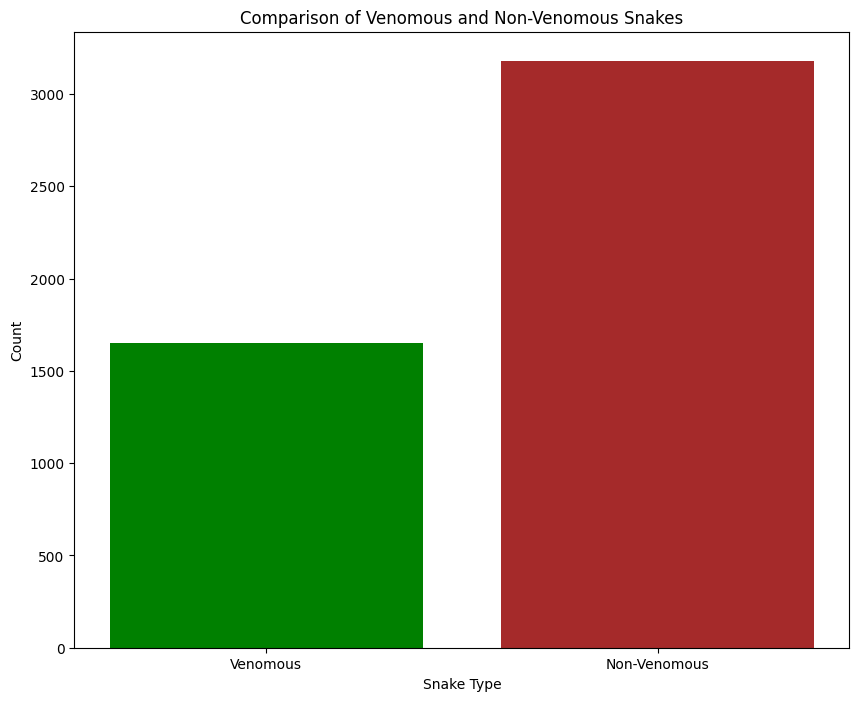

In [76]:
categories = ['Venomous', 'Non-Venomous']
counts = [num_venomous, num_non_venomous]

plt.figure(figsize=(10, 8))
plt.bar(categories, counts, color=['green', 'brown'])
plt.xlabel('Snake Type')
plt.ylabel('Count')
plt.title('Comparison of Venomous and Non-Venomous Snakes')
plt.show()

3. Preprocessing the Images

In [77]:
def load_images_and_labels(data_dir):
    # Label 0 if venomous
    # Label 1 if non-venomous
    X = []
    y = []

    for label, folder in enumerate(['venomous', 'non_venomous']):
        folder_path = os.path.join(data_dir, folder)
        images_in_folder = os.listdir(folder_path)

        for file in images_in_folder:
            file_path = os.path.join(folder_path, file)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (224, 224))  # Resizing images to 224x224
            image = image.astype('float32') / 255.0  # Normalization to values [0,1]
            X.append(image)
            y.append(label)

        # For venomous snakes, duplicate the images and add augmentation
        if folder == 'venomous':
            venomous_images = X[-len(images_in_folder):]  # Get the original venomous images

            # Data augmentation for the duplicated images
            datagen = ImageDataGenerator(
                horizontal_flip=True,
                zoom_range=0.3
            )
            
            for image in venomous_images:
                augmented_image = datagen.random_transform(image)
                augmented_image = np.clip(augmented_image, 0, 1)
                
                X.append(augmented_image)
                y.append(label)

    return np.array(X), np.array(y)

4. Training and Testing Split

In [78]:
X, y = load_images_and_labels(data_dir)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Should be 6,484 images total
print("Number of images for training:", len(X_train))
print("Number of images for testing:", len(X_test))

Number of images for training: 5187
Number of images for testing: 1297


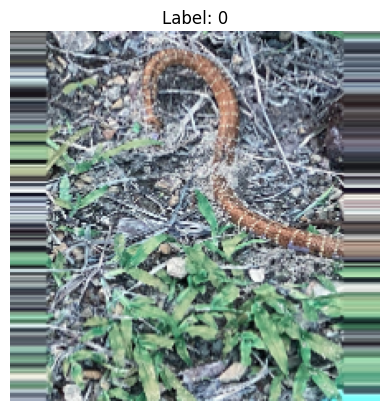

In [111]:
idx = np.random.randint(len(X_train))
image = X_train[idx]
label = y_train[idx]
plt.imshow(image)
plt.title('Label: ' + str(label))
plt.axis('off')
plt.show()

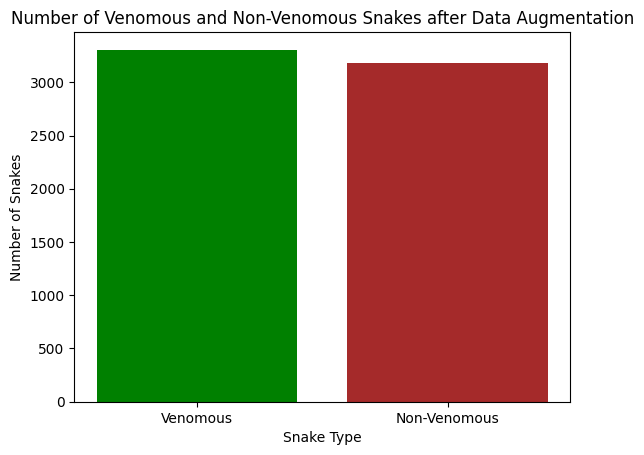

In [112]:
num_venomous = np.sum(y == 0)
num_non_venomous = np.sum(y == 1)

labels = ['Venomous', 'Non-Venomous']
counts = [num_venomous, num_non_venomous]

plt.bar(labels, counts, color=['green', 'brown'])
plt.xlabel('Snake Type')
plt.ylabel('Number of Snakes')
plt.title('Number of Venomous and Non-Venomous Snakes after Data Augmentation')
plt.show()

5. Creating the Models

In [113]:
def create_model(model_name):
    if model_name == 'ResNet50':
        base_model = ResNet50(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 512
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    elif model_name == 'VGG16':
        base_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 256
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    elif model_name == 'DenseNet201':
        base_model = DenseNet201(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 512
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    
    pretrained_model = Sequential([
        base_model,
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    pretrained_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return pretrained_model

6. Evaluating the Models

In [114]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    print("Training the model...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    print("Training finished.")
    
    print("Evaluating the model on test data...")
    _, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Evaluation finished.")
    
    return history, accuracy

7. Train the Models and Identify Mean Performance of each Algorithm

Training and evaluating ResNet50
Training the model...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.5445 - loss: 0.8068 - val_accuracy: 0.5297 - val_loss: 1.1252
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.6099 - loss: 0.6484 - val_accuracy: 0.5359 - val_loss: 1.1745
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.6290 - loss: 0.6311 - val_accuracy: 0.6268 - val_loss: 0.6218
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.6457 - loss: 0.6205 - val_accuracy: 0.6284 - val_loss: 0.6508
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.6451 - loss: 0.6164 - val_accuracy: 0.6322 - val_loss: 0.6370
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.6685 - loss: 0.6014 - val_accuracy: 0.5675 - val_loss: 0.7018
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6650 - loss: 0.6048 - val_accuracy: 0.6130 - val_loss: 0.6508
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25

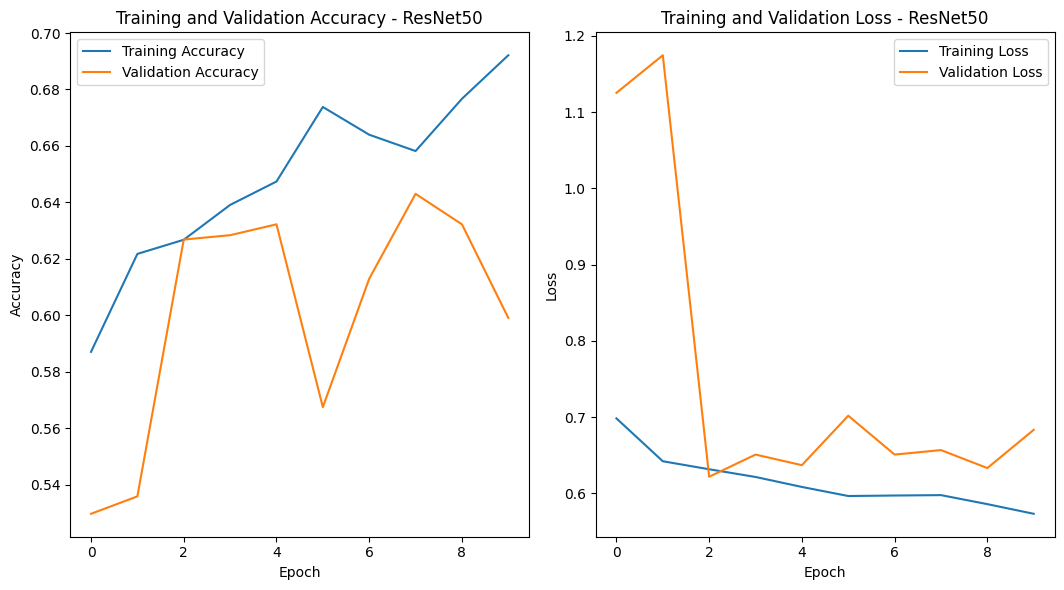

41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step


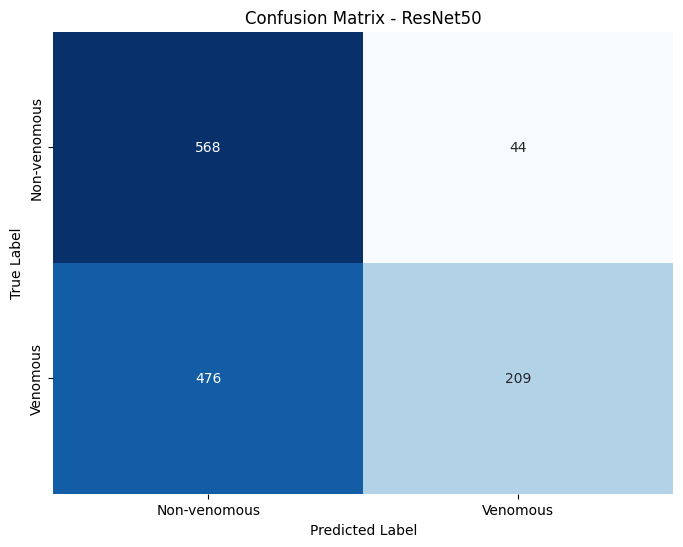

Classification Report for ResNet50
              precision    recall  f1-score   support

           0       0.83      0.31      0.45       685
           1       0.54      0.93      0.69       612

    accuracy                           0.60      1297
   macro avg       0.69      0.62      0.57      1297
weighted avg       0.69      0.60      0.56      1297

Training and evaluating VGG16
Training the model...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.5897 - loss: 0.6653 - val_accuracy: 0.6677 - val_loss: 0.6096
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.6395 - loss: 0.6241 - val_accuracy: 0.6546 - val_loss: 0.5874
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 429s 3s/step - accuracy: 0.6729 - loss: 0.5838 - val_accuracy: 0.6500 - val_loss: 0.5953
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.6667 - loss: 0.5845 - val_accuracy: 0.6939 - val_loss: 0.5727
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.691

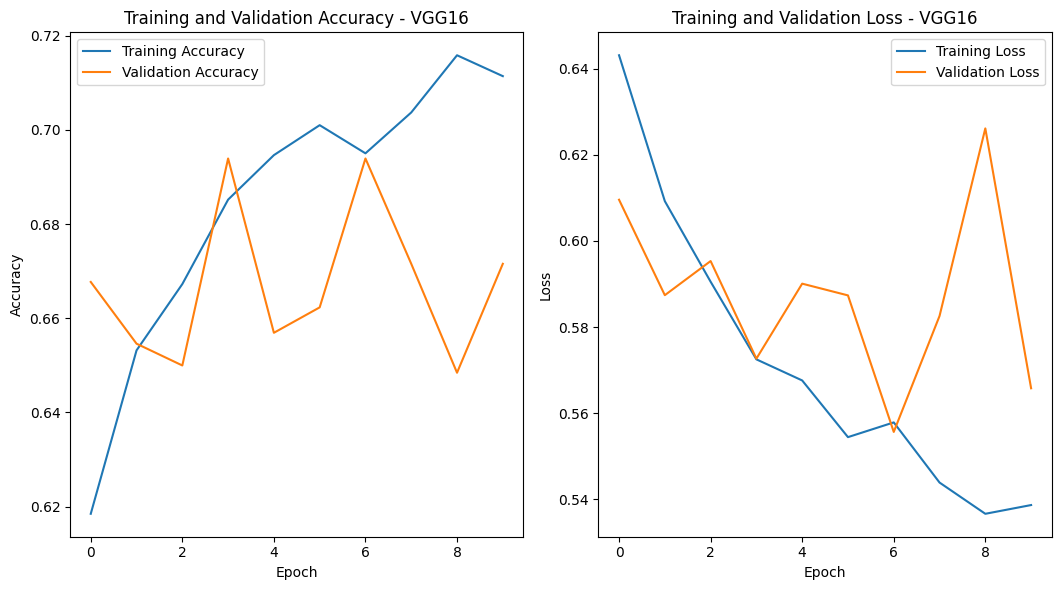

41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step


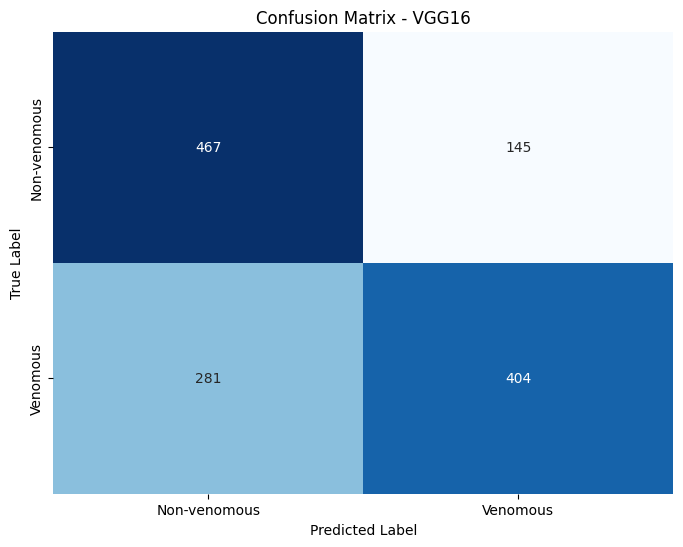

Classification Report for VGG16
              precision    recall  f1-score   support

           0       0.74      0.59      0.65       685
           1       0.62      0.76      0.69       612

    accuracy                           0.67      1297
   macro avg       0.68      0.68      0.67      1297
weighted avg       0.68      0.67      0.67      1297

Training and evaluating DenseNet201
Training the model...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 589s 3s/step - accuracy: 0.7030 - loss: 0.5912 - val_accuracy: 0.7456 - val_loss: 0.5081
Epoch 2/10
 79/163 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - accuracy: 0.8143 - loss: 0.4127

KeyboardInterrupt: 

In [115]:
models = {'ResNet50': create_model('ResNet50'), 'VGG16': create_model('VGG16'), 'DenseNet201': create_model('DenseNet201')}
accuracies = {}

for name, model in models.items():
    print("Training and evaluating", name)
    history, accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
    accuracies[name] = accuracy
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy - ' + name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss - ' + name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    # Sort confusion matrix for venomous and non-venomous labels
    cm_sorted = np.zeros_like(cm)
    cm_sorted[0, 0] = cm[1, 1]
    cm_sorted[0, 1] = cm[1, 0]
    cm_sorted[1, 0] = cm[0, 1]
    cm_sorted[1, 1] = cm[0, 0]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_sorted, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix - ' + name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=[0.5, 1.5], labels=['Non-venomous', 'Venomous'])  # Update xticks labels
    plt.yticks(ticks=[0.5, 1.5], labels=['Non-venomous', 'Venomous'])  # Update yticks labels
    plt.show()


    print("Classification Report for", name)
    print(classification_report(y_test, y_pred, zero_division='warn'))

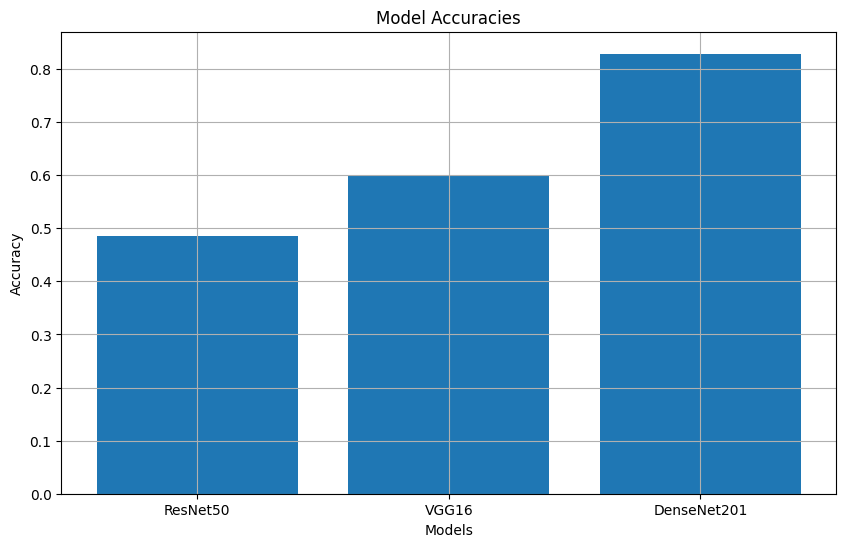

In [ ]:
model_names = list(accuracies.keys())
model_accuracies = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.grid(True)
plt.show()